##Imbalanced data: same number of 0 and 1 datapoints, but within class 1, writer 085 has the majority (10) of datapoints while all other writers have an equal but lower number (4) of datapoints each

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import glob
import os
import pickle
from bs4 import BeautifulSoup
# data_path = '/Users/ruchiraravishankar/Downloads/iam_dataset/'
data_path = '/content/drive/MyDrive/iam_dataset/'
save_path = "/content/drive/MyDrive/iam_dataset/saved_model"

In [3]:
# toggles to change training and nodes

# transfer learning toggle
fc = True
conv = False
plain_inf = False

# toggle to save model
save_model = False
# toggle to save results  
save_results = False

if plain_inf:
  save_model = False

In [4]:
labelled_data = np.load(data_path + 'labelled_data.npy')

print(labelled_data.shape)

(4901, 2)


In [5]:
# changing the distribution here of class 0
labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

print(labelled_data_0.shape)

labelled_data_0 = labelled_data_0[:202]
print(labelled_data_0.shape)

print(np.unique(labelled_data_0[:,1]))

(693, 2)
(202, 2)
['000']


In [6]:
remove_000 = labelled_data[labelled_data[:,1]!='000']

print(np.unique(remove_000[:,1]))
print(np.unique(remove_000[:,1]).shape)

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)


In [7]:
y = [remove_000[remove_000[:,1]==k] for k in np.unique(remove_000[:,1])]
print(len(y))

49


In [8]:
# changing the distribution here of class 1
labelled_data_1 = []
for i in range(len(y)):
    if i == 0:
      labelled_data_1.append(y[i][:10])
    else:
      labelled_data_1.append(y[i][:4])
print(len(labelled_data_1))

labelled_data_1 = np.concatenate(labelled_data_1)

print(labelled_data_1.shape)

49
(202, 2)


In [9]:
print(labelled_data_1.shape)

(202, 2)


<BarContainer object of 49 artists>

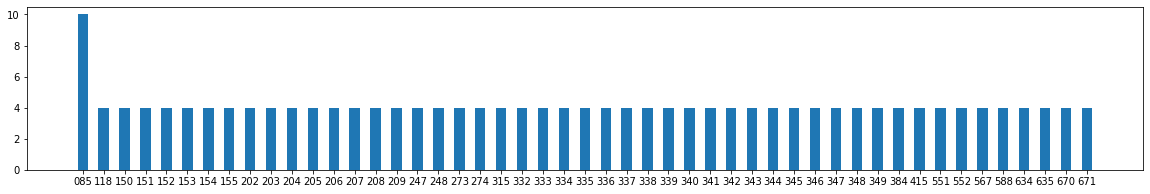

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
labelled_data_1_count = Counter(labelled_data_1[:,1])
plt.figure(figsize=(20,3))
plt.bar(labelled_data_1_count.keys(), labelled_data_1_count.values(), width=0.5)

In [11]:
print(np.unique(labelled_data_1[:,1]))

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']


In [12]:
labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
np.random.shuffle(labelled_data_new)
print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

(404, 2)


<BarContainer object of 2 artists>

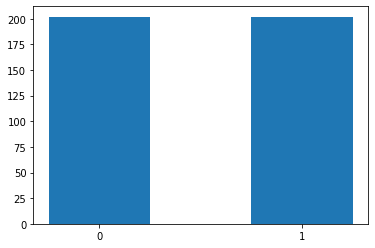

In [13]:
class_counts = {'0':len(labelled_data_0),'1':len(labelled_data_1)}
plt.bar(class_counts.keys(), class_counts.values(), width=0.5)

In [14]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(180,) (134,) (90,) (180,) (134,) (90,)


In [15]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [16]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [17]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
augsamps_test, auglbls_test = augment(X_test, y_test)
augsamps_val, auglbls_val = augment(X_val, y_val)

In [18]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, augsamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)

aug_samps_val = reduce(operator.add, augsamps_val)
aug_lbls_val = reduce(operator.add, auglbls_val)

print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

print(len(aug_samps_val))
print(len(aug_lbls_val))

29712
29712
24622
24622
15993
15993


In [19]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)
aug_samps_arr_val = np.array(aug_samps_val)
aug_lbls_arr_val = np.array(aug_lbls_val)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)
print(aug_samps_arr_val.shape)
print(aug_lbls_arr_val.shape)

(29712, 113, 113)
(29712,)
(24622, 113, 113)
(24622,)
(15993, 113, 113)
(15993,)


In [20]:
def transform_data_aug_samps(data):
  data = data.reshape(data.shape[0], 1, CROP_SIZE, CROP_SIZE)
  data = data.astype('float16')
  data /= 255.0
  return data

In [21]:
X_train = transform_data_aug_samps(aug_samps_arr)
X_val = transform_data_aug_samps(aug_samps_arr_val)
X_test = transform_data_aug_samps(aug_samps_arr_test)

In [22]:
def convert_y_labels(labels):
  new = np.unique(labels)
  print(new)

  labels[labels !='000'] = 1
  new = np.unique(labels)
  print(new)

  labels[labels=='000'] = 0
  new = np.unique(labels)
  print(new)

  print(labels.shape)

  labels = labels.astype('float16')

  print(np.unique(labels))
  return labels

In [23]:
y_train = convert_y_labels(aug_lbls_arr)
y_test = convert_y_labels(aug_lbls_arr_test)
y_val = convert_y_labels(aug_lbls_arr_val)

['000' '085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204'
 '205' '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333'
 '334' '335' '336' '337' '338' '339' '340' '342' '343' '345' '346' '347'
 '348' '349' '384' '415' '552' '567' '588' '634' '635' '670' '671']
['000' '1']
['0' '1']
(29712,)
[0. 1.]
['000' '085' '118' '150' '152' '155' '202' '203' '205' '206' '208' '273'
 '315' '332' '334' '335' '337' '338' '339' '340' '341' '342' '343' '344'
 '345' '346' '347' '349' '384' '415' '551' '552' '567' '588' '635' '670'
 '671']
['000' '1']
['0' '1']
(24622,)
[0. 1.]
['000' '085' '150' '151' '152' '153' '154' '206' '207' '208' '209' '274'
 '332' '333' '334' '336' '341' '342' '343' '344' '347' '348' '415' '551'
 '552' '567' '588']
['000' '1']
['0' '1']
(15993,)
[0. 1.]


In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(29712, 1, 113, 113)
(29712,)
(24622, 1, 113, 113)
(24622,)
(15993, 1, 113, 113)
(15993,)


In [25]:
torch.manual_seed(42)
CUDA = True
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [26]:
from torch.utils.data import TensorDataset, DataLoader


tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()



# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [27]:
tensor_x_val = torch.Tensor(X_val).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_val = torch.Tensor(y_val).type(torch.cuda.FloatTensor).long()
# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

val_dataset = TensorDataset(tensor_x_val,tensor_y_val) # create your datset
val_dataloader = DataLoader(val_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [28]:
tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).long().type(torch.cuda.FloatTensor).long()

# tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(y_test).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True) # create your dataloader

In [29]:
tensor_x_train.shape

torch.Size([29712, 1, 113, 113])

In [30]:
# import torch
from torch import nn
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.fc1 = nn.Linear(4320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.relu(self.max_pool2d(self.conv1(x)))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv2(x))))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv3(x))))
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.conv_drop(x)
        x = self.fc2(x)
        return x

In [31]:
model=Binary_Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

# import torch.optim.lr_scheduler.StepLR
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [32]:
try:
    print('Loading checkpoint: %s' % save_path +'/model_3_convs.pt')
    path = torch.load(save_path +'/model_3_convs.pt', map_location=torch.device(device))
    epoch = path['epoch']
    model.load_state_dict(path['model'])
    optimizer.load_state_dict(path['optimizer'])
except Exception as e:
  print("nothing happened")
  print(e)

Loading checkpoint: /content/drive/MyDrive/testing_proj/iam_dataset/saved_model/model_3_convs_latest.pt


In [33]:
print(model.parameters)

<bound method Module.parameters of Binary_Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [34]:
print(device)

cuda


In [35]:
if fc or conv:
  for param in model.parameters():
    param.requires_grad = False

In [36]:
if conv:
  for param in model.conv3.parameters():
    param.requires_grad = True

In [37]:
if fc or conv:
  num_ftrs = model.fc2.in_features
  print(num_ftrs)
  model.fc2 = nn.Linear(num_ftrs, 2).to(device)

1024


In [38]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
True
True
False
False
True
True


In [39]:
train_losses = []
train_loss_record = []

In [40]:
from datetime import datetime
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
def train(epoch):
    print('Start Epoch {} Training...'.format(epoch))
    model.train()
    train_loss = []
    train_loss_sum = []
    for idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #  forward-pass
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy())
        train_loss_sum.append(loss)
        if ((idx +1) % 5000) == 0:
          print(train_log_string % (datetime.now(), epoch, idx + 1, len(train_dataloader), np.mean(train_loss)))
          train_loss = []
    mean_tr = torch.mean(torch.stack(train_loss_sum))
    print('Train Loss at epoch {}: {}\n'.format(epoch, mean_tr))
    train_loss_record.append(mean_tr)
    return train_loss_record

In [41]:
# for epoch in range(15):
#     tlr = train(epoch)

import time
if fc or conv:
  train(1)
  torch.cuda.synchronize()

  times = []
  for epoch in range(15):
      start_epoch = time.time()
      tlr = train(epoch)
      torch.cuda.synchronize()
      end_epoch = time.time()
      elapsed = end_epoch - start_epoch
      times.append(elapsed)


  avg_time = sum(times)/15
  print(avg_time)

Start Epoch 1 Training...
Train Loss at epoch 1: 0.6550576090812683

Start Epoch 0 Training...
Train Loss at epoch 0: 0.6310067176818848

Start Epoch 1 Training...
Train Loss at epoch 1: 0.6184192299842834

Start Epoch 2 Training...
Train Loss at epoch 2: 0.6080632209777832

Start Epoch 3 Training...
Train Loss at epoch 3: 0.6026765704154968

Start Epoch 4 Training...
Train Loss at epoch 4: 0.5957402586936951

Start Epoch 5 Training...
Train Loss at epoch 5: 0.5930639505386353

Start Epoch 6 Training...
Train Loss at epoch 6: 0.5899810791015625

Start Epoch 7 Training...
Train Loss at epoch 7: 0.5879925489425659

Start Epoch 8 Training...
Train Loss at epoch 8: 0.5837777853012085

Start Epoch 9 Training...
Train Loss at epoch 9: 0.5839278697967529

Start Epoch 10 Training...
Train Loss at epoch 10: 0.5815083384513855

Start Epoch 11 Training...
Train Loss at epoch 11: 0.5810409188270569

Start Epoch 12 Training...
Train Loss at epoch 12: 0.5787440538406372

Start Epoch 13 Training...
T

In [42]:
# conv time 8.539720948537191
# fc time 5.401253032684326

(16,)


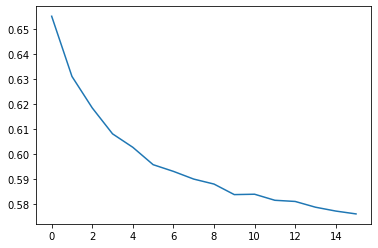

In [43]:
import matplotlib.pyplot as plt
if fc or conv:
  temp = [t.detach().cpu().numpy() for t in tlr]
  arr = np.array(temp)
  print(arr.shape)

  plt.plot(arr)

In [44]:
# # save trained model
if save_model:
  state_dict = {
      # 'epoch': epoch,
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
  }
  if fc:
    torch.save(state_dict, save_path+'/model_3_convs_node_4_fc.pt')
    print('Model saved!\n')
  elif conv:
    torch.save(state_dict, save_path+'/model_3_convs_node_4_conv.pt')
    print('Model saved!\n')
  else:
    print("set NODE or fc/conv")

In [45]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(1538, 16, 2) (1538, 16)


In [46]:
print(prediction.reshape(-1).shape)

(24608,)


In [47]:
import pandas as pd
res = pd.DataFrame(result.reshape(-1,2))
pred = pd.DataFrame(prediction.reshape(-1))

# res.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/results_imbal_1_conv_3_transf_conv.csv", header=False, index=False)
# pred.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/pred__imbal_1_conv_3_transf_conv.csv", header=False, index=False)

In [48]:
print(res.shape, pred.shape)

(24608, 2) (24608, 1)


In [49]:
y_test_new = y_test[:result.reshape(-1,2).shape[0]]

In [50]:
print(y_test_new.shape)

(24608,)


In [51]:
result_df = pd.DataFrame({'ground truth': y_test_new, 'NN output': prediction.reshape(-1), 'probs 0': res[0], 'probs 1': res[1]})
result_df

,ground truth,NN output,probs 0,probs 1
0,1.0,1,0.443247,0.556753
1,1.0,1,0.444481,0.555519
2,1.0,1,0.388976,0.611024
3,1.0,1,0.382649,0.617351
4,1.0,1,0.352287,0.647713
...,...,...,...,...
24603,1.0,1,0.309245,0.690755
24604,1.0,1,0.312525,0.687475
24605,1.0,1,0.333178,0.666822
24606,1.0,1,0.281382,0.718618


In [52]:
# work out the accuracy and other metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
actual = result_df['ground truth']
predicted = result_df['NN output']
# confusion matrix
matrix = confusion_matrix(actual, predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual, predicted, labels=[0,1]).reshape(-1)
print('Outcome values : \n', tn, fp, fn, tp)

# tn, fp, fn, tp

# classification report for precision, recall f1-score and accuracy
matrix_2 = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix_2)

Confusion matrix : 
 [[    4 15568]
 [    1  9035]]
Outcome values : 
 4 15568 1 9035
Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.00      0.00     15572
           1       0.37      1.00      0.54      9036

    accuracy                           0.37     24608
   macro avg       0.58      0.50      0.27     24608
weighted avg       0.64      0.37      0.20     24608



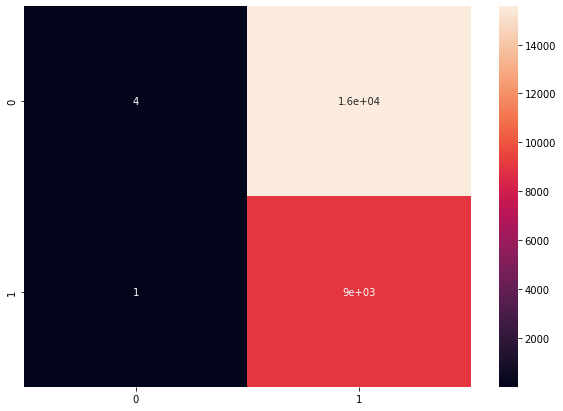

In [53]:
import matplotlib.pyplot as plt

import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True)

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
matrix_3 = classification_report(actual,predicted,labels=[0,1], output_dict=True)
print('Classification report : \n',matrix_3)
accuracy_score(actual, predicted)

Classification report : 
 {'0': {'precision': 0.8, 'recall': 0.00025687130747495504, 'f1-score': 0.0005135777107273544, 'support': 15572}, '1': {'precision': 0.3672316384180791, 'recall': 0.9998893315626384, 'f1-score': 0.5371741133803026, 'support': 9036}, 'accuracy': 0.3673195708712614, 'macro avg': {'precision': 0.5836158192090396, 'recall': 0.5000731014350567, 'f1-score': 0.268843845545515, 'support': 24608}, 'weighted avg': {'precision': 0.6410884706089792, 'recall': 0.3673195708712614, 'f1-score': 0.19757407024609316, 'support': 24608}}


0.3673195708712614

In [55]:
matrix_df = pd.DataFrame(matrix).transpose()
matrix_3_df = pd.DataFrame(matrix_3).transpose()
# matrix_df.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/conf_matrix_imbal_1_3conv_transf_conv.csv", header=False, index=False)

if save_results:
  if fc:
    matrix_3_df.to_csv(save_path + "/classification_report_node4_3conv_fc_retrain.csv", header=True, index=True)
  elif conv:
    matrix_3_df.to_csv(save_path + "/classification_report_node4_3conv_conv_retrain.csv", header=True, index=True)
  elif plain_inf:
    matrix_3_df.to_csv(save_path + "/classification_report_node4_3conv_pi.csv", header=True, index=True)
  else:
    print("set fc/conv/plain_inf")
# pd.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/classification_report.txt",matrix)
